In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/MLDL/semi-inat-2021.zip /
!unzip -qq /semi-inat-2021.zip 

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

l_train_path = './l_train'
u_train_path = './u_train'
val_path = './val'
test_path = './test'
classes = 810
max_width = 300
max_length = 300

input_size = 224

## Image Transforms

## apply additional transforms here:
img_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img_augmentation = transforms.Compose([
        transforms.Resize(input_size),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5)
])

##following three are required 
# this one is to convert to pytorch format 
to_pytorch_tensor = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float)
])

# some images are not 3 channels
to_3channels = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1))
        ])

# padding to max size
def padding_size(image):
    sizes = image.size
    width_diff = max_width - sizes[0]
    length_diff = max_length - sizes[1]
    left = width_diff // 2
    top = length_diff // 2
    right = width_diff-left
    bottom = length_diff-top
    return (left, top, right, bottom)

#for l_train and val
#there are 810 folders from 0 to 809
#will return image and label
#if use the default transfrom, image will be a pytorch tensor
#pass use_memory = False, if ran out of ram
class iNat_dataset_labeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None, 
                 use_memory = True):
      self.data_type = data_type
      if self.data_type == 'l_train':
        self.data_dir = os.path.join(l_train_path, 'l_train')
      elif self.data_type == 'val':
        self.data_dir = os.path.join(val_path, 'val')
      #if load all data into memeory
      self.use_memory = use_memory
      self.transform = tf
      self.data = []
      self.labels = []
      for i in range(classes):
        path = os.path.join(self.data_dir, str(i))
        images = os.listdir(path)
        for j in range(len(images)):
          file = os.path.join(path, images[j])
          if self.use_memory:
            img = Image.open(file)
            img = transforms.functional.pad(img, padding_size(img)) 
            self.data.append(img)
          else:
            self.data.append(file)
          self.labels.append(i)

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      if self.use_memory:
        img = self.data[idx]
      else:
        img = Image.open(self.data[idx])
        img = transforms.functional.pad(img, padding_size(img))
 
      img = to_pytorch_tensor(img)
      if img.size(0) != 3:
        img = to_3channels(img)
      if self.transform:
        img = self.transform(img)
      
      return img, self.labels[idx]

#for u_train and test
#return image and its file name 
class iNat_dataset_unlabeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'u_train':
        self.data_dir = os.path.join(u_train_path, 'u_train')
      elif self.data_type == 'test':
        self.data_dir = os.path.join(test_path, 'test')

      self.transform = tf
      self.data = []
      self.names = []

      images = os.listdir(self.data_dir)
      for i in range(len(images)):
        file = os.path.join(self.data_dir, images[i])
        img = Image.open(file)
        self.data.append(img)
        self.names.append(images[i])

    def __len__(self):
      return len(self.names)

    def __getitem__(self, idx):
      img = self.data[idx]
      img = transforms.functional.pad(img, padding_size(img))
      img = to_pytorch_tensor(img)
      
      if img.size(0) != 3:
        img = to_3channels(img) 

      if self.transform:
        img = self.transform(img)
      
      return img, self.names[idx]

In [ ]:
l_train_batch_size = 80
val_batch_size = 80

#need to use high ram setting if set true
#need about 14-15 gb ram
use_memory = True

In [ ]:
l_train_dataset=iNat_dataset_labeled(data_type="l_train", tf=img_augmentation)
l_train_dataloader = DataLoader(l_train_dataset, batch_size=l_train_batch_size, shuffle=True)

val_dataset=iNat_dataset_labeled(data_type="val", tf=img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

test_dataset=iNat_dataset_unlabeled(data_type="test", tf=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

In [ ]:
lr = 0.0001
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

epoch: 1  train loss: 6.040892038188997 val accuracy: 0.049135802469135806
ETA of completion: 37.39442122379939 minutes
epoch: 2  train loss: 4.6778547920164515 val accuracy: 0.10148148148148148
ETA of completion: 36.02377309799194 minutes
epoch: 3  train loss: 3.7052567747772716 val accuracy: 0.14098765432098764
ETA of completion: 34.705569899082185 minutes
epoch: 4  train loss: 2.944529269562393 val accuracy: 0.17851851851851852
ETA of completion: 33.22561996777852 minutes
epoch: 5  train loss: 2.3283187952197966 val accuracy: 0.23209876543209876
ETA of completion: 31.97851876417796 minutes
epoch: 6  train loss: 1.7406903954802966 val accuracy: 0.26271604938271603
ETA of completion: 30.716685962677 minutes
epoch: 7  train loss: 1.5623451207504897 val accuracy: 0.27012345679012345
ETA of completion: 29.621308441956838 minutes
epoch: 8  train loss: 1.433700192170065 val accuracy: 0.2817283950617284
ETA of completion: 28.21972717444102 minutes
epoch: 9  train loss: 1.3171882873675862 va

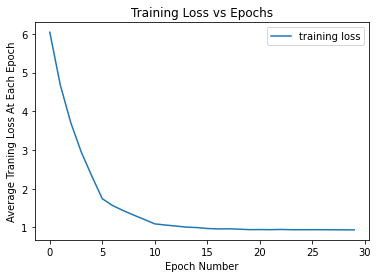

In [ ]:
train_loss = []
for epoch in range(num_epochs):
  time1 = time.time()
  model.train()
  total_loss = 0
  for data, target in l_train_dataloader:
    optimizer.zero_grad()
    if gpu_boole:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  scheduler.step()
  train_loss.append(total_loss/len(l_train_dataloader))

  model.eval()
  correct_sum = 0
  with torch.no_grad():
    for data, target in val_dataloader:
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      correct_sum += (predicted.float() == target.float()).sum().item()
  time2 = time.time()
  print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
        'val accuracy:', correct_sum/len(val_dataset))
  print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')
  if correct_sum/len(val_dataset) >= 0.50:
    break
plt.plot(train_loss, label = 'training loss')
plt.xlabel('Epoch Number')
plt.ylabel('Average Traning Loss At Each Epoch')
plt.legend()
plt.title('Training Loss vs Epochs')
plt.show()

Save/load checkpoints

In [ ]:
path1 = '/content/drive/MyDrive/MLDL/saved_models/ResNet.pth'
path2 = '/content/drive/MyDrive/MLDL/saved_models/ResNet_optimizer.pth'
path3 = '/content/drive/MyDrive/MLDL/saved_models/ResNet_scheduler.pth'

In [ ]:
import numpy as np
arr = np.array(train_loss)
file = open("/content/drive/MyDrive/MLDL/saved_models/ResNet_losses.txt", "a")
content = str(arr)
file.write(content)
file.close()

In [ ]:
torch.save(model.state_dict(), path1)
torch.save(optimizer.state_dict(), path2)
torch.save(scheduler.state_dict(), path3)

In [ ]:
state_dict = torch.load(path1) 
model.load_state_dict(state_dict)
state_dict1 = torch.load(path2)
optimizer.load_state_dict(state_dict1)
state_dict2 = torch.load(path3)
scheduler.load_state_dict(state_dict2)

Test

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/MLDL/saved_models/ResNet.pth'))
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

In [ ]:
model.eval()
correct_sum = 0
total = 0
with torch.no_grad():
  for data, target in l_train_dataloader:
    if gpu_boole:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    correct_sum += (predicted.float() == target.float()).sum().item()
    total += target.size(0)
print('train accuracy:', correct_sum/total)

train accuracy: 0.8904433700236601


In [ ]:
model.eval()
correct_sum = 0
total = 0
with torch.no_grad():
  for data, target in val_dataloader:
    if gpu_boole:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    correct_sum += (predicted.float() == target.float()).sum().item()
    total += target.size(0)
print('val accuracy:', correct_sum/total)

val accuracy: 0.31037037037037035


Export the test dataset result to .csv file

In [ ]:
import csv 
f = open('resnet_solutions.csv', 'w')
writer = csv.writer(f)
header = ['Id', 'Category']
writer.writerow(header)
model.eval()
with torch.no_grad():
  for data, name in test_dataloader:
      if gpu_boole:
          data = data.cuda()
      output = model(data)
      predicted = torch.topk(output.data, 5).indices
      
      pred_str = ""
      for i in range(4):
        pred_str += (str(predicted[0][i].item()) + " ")
      pred_str += str(predicted[0][4].item())
      line = [name[0], pred_str]
      writer.writerow(line)
f.close()